In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

In [2]:
warnings.filterwarnings('ignore')
from keras import models 
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
import plotly.graph_objects as go

### Context
NASA's Magellan (https://www2.jpl.nasa.gov/magellan/) spacecraft was launched on May 4, 1989 and arrived at Venus on August 10, 1990. The primary objectives of the Magellan mission were to map the surface of Venus with a synthetic aperture radar (SAR) and to determine the topographic relief of the planet. At the completion of radar mapping 98% of the surface was imaged at resolutions better than 100 m, and many areas were imaged multiple times.
In the analysis of the data captured by the spacecraft they found volcanoes on the surface on Venus, volcanoes that can be used to make a automatic machine that can detect them.

### Content
We present the data split into train and test. The input data (trainimages.csv and testimages.csv) consist on Images of one chanel 110x110, pixels from 0 to 255, where every image is one row of 12100 columns (all the 110 rows of 110 columns), this images can contain more then one volcano or maybe none . Associated to this we present the label data or "ground truth" (trainlabels.csv and testlabels.csv), which contains four columns, described here:

Volcano?: if in the image there are volcanoes (Main target), 1 or 0.
for Volcano?=0 this three next features are NaN

Type: 1= definitely a volcano,2 =probably, 3= possibly, 4= only a pit is visible
Radius: is the radius of the volcano in the center of the image, in pixels
Number Volcanoes: The number of volcanoes in the image
The images that have volcanoes, have one centered on the image. The authors quote "ground truth" as a reminder that there is no absolute ground truth for this dataset. No one has been to Venus and image quality does not permit 100%, unambiguos identification of the volcanoes, even by human experts.

The data is unbalanced and that has to be taken account, the number of volcanoes is lower than no volcanoes.

### Missing Values
Some images contain blank (black) regions which resulted from gaps in the Magellan acquisition or communication processes. These regions can generally be ignored.

### Acknowledgements
The original dataset has been carried out in part by the Jet Propulsion Laboratory, California Institute of Technology, under contract with the National Aeroenautics and Space Administration, and thanks to UCI Machine Learning Repository (http://archive.ics.uci.edu/ml) we use the original dataset to create this one to you in Kaggle!

Inspiration
JARtool (jartool@aig.jpl.nasa.go) was a pioneering effort to develop an automatic system for cataloging small volcanoes in the large set of Venus images returned by the Magellan spacecraft. We use the original dataset to create this one with the same purpose.

In [4]:
IMAGE_SHAPE = (110,110,1)

In [5]:
x_train = pd.read_csv("volcanoes_train/train/train_images.csv", header=None)
y_train = pd.read_csv("volcanoes_train/train/train_labels.csv")

In [6]:
x_test = pd.read_csv("volcanoes_test/test/test_images.csv", header = None)
y_test = pd.read_csv("volcanoes_test/test/test_labels.csv")

### Exploratory Analysis of Training Data 

In [7]:
x_train.head()

0      1      2      3      4      5      6      7      8      9      ...  \
0     95    101     99    103     95     86     96     89     70    104  ...   
1     91     92     91     89     92     93     96    101    107    104  ...   
2     87     70     72     74     84     78     93    104    106    106  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4    114    118    124    119     95    118    105    116    123    112  ...   

   12090  12091  12092  12093  12094  12095  12096  12097  12098  12099  
0    111    107     92     89    103     99    117    116    118     96  
1    103     92     93     95     98    105    104    100     90     81  
2     84     71     95    102     94     80     91     80     84     90  
3     94     81     89     84     80     90     92     80     88     96  
4    116    113    102     93    109    104    106    117    111    115  

[5 rows x 12100 columns]

In [8]:
x_train.shape

(7000, 12100)

In [9]:
y_train.head()

Volcano?  Type  Radius  Number Volcanoes
0         1   3.0   17.46               1.0
1         0   NaN     NaN               NaN
2         0   NaN     NaN               NaN
3         0   NaN     NaN               NaN
4         0   NaN     NaN               NaN

In [10]:
y_train.shape

(7000, 4)

In [11]:
volcano_dict = {1:"Volcano", 0:"No Volcano"}
y_train["label"] = y_train["Volcano?"].apply(lambda x: volcano_dict[x])

train_counts = y_train['label'].value_counts()

fig = go.Figure()
fig.add_trace(go.Bar(x=train_counts.index, y=train_counts.values))
fig.update_layout(title="Distribution of Class", xaxis_type="category")
fig.show()

### Exploratory Analysis of Test Data 

In [12]:
x_test.head()

0      1      2      3      4      5      6      7      8      9      ...  \
0    107    116    108    101    107    109    108    110    100    109  ...   
1     93     95     98    100     90    100    108     98     90    103  ...   
2    108    108     92    116    116    140    126    104    112    103  ...   
3    165    164    156    159    151    120    103    114    114    116  ...   
4    105    106     84    115    121    103     94    108    103     91  ...   

   12090  12091  12092  12093  12094  12095  12096  12097  12098  12099  
0    111    110    109    109    101    106    106    117    130    134  
1     86     93     59     88     89     89     92     99     92    113  
2    118    111    113    107    107    121    141    160    131    138  
3     69     96    109     91     94     83     48     69     86     75  
4     92     89     96     89     91    102     99     90     90     73  

[5 rows x 12100 columns]

In [13]:
x_test.shape

(2734, 12100)

In [14]:
y_test.head()

Volcano?  Type  Radius  Number Volcanoes
0         0   NaN     NaN               NaN
1         0   NaN     NaN               NaN
2         1   1.0   17.00               1.0
3         0   NaN     NaN               NaN
4         1   3.0   15.13               1.0

In [15]:
y_test.shape

(2734, 4)

In [16]:
y_test["label"] = y_test["Volcano?"].apply(lambda x: volcano_dict[x])

test_counts = y_test['label'].value_counts()

fig2 = go.Figure()
fig2.add_trace(go.Bar(x=test_counts.index, y=test_counts.values))
fig2.update_layout(title="Distribution of Class", xaxis_type="category")
fig2.show()

In [17]:
x_train_shaped = x_train.copy()
x_test_shaped = x_test.copy()

#Reshape images represented by rows in x_train and x_test into a 2D image format
x_train_shaped = np.resize(x_train_shaped, (7000, 110,110))
x_test_shaped = np.resize(x_test_shaped, (2734, 110,110))

In [18]:
from matplotlib import pyplot as plt

def draw_images(feature):
    featureTypes = (y_train.groupby([feature])[feature].nunique()).index
    f, ax = plt.subplots(len(featureTypes)*2, 5, figsize=(12,6*len(featureTypes)))
    for i in range(len(featureTypes)*2):
        typ = featureTypes[int(i/2)]
        sample = y_train[y_train[feature]==typ].sample(5)
        for j in range(5):
            imageIndex = sample.iloc[j].name
            image = x_train_shaped[imageIndex]
            ax[i, j].imshow(image, resample=True)
            ax[i, j].set_title(typ, fontsize=13)
    plt.tight_layout()
    plt.show()

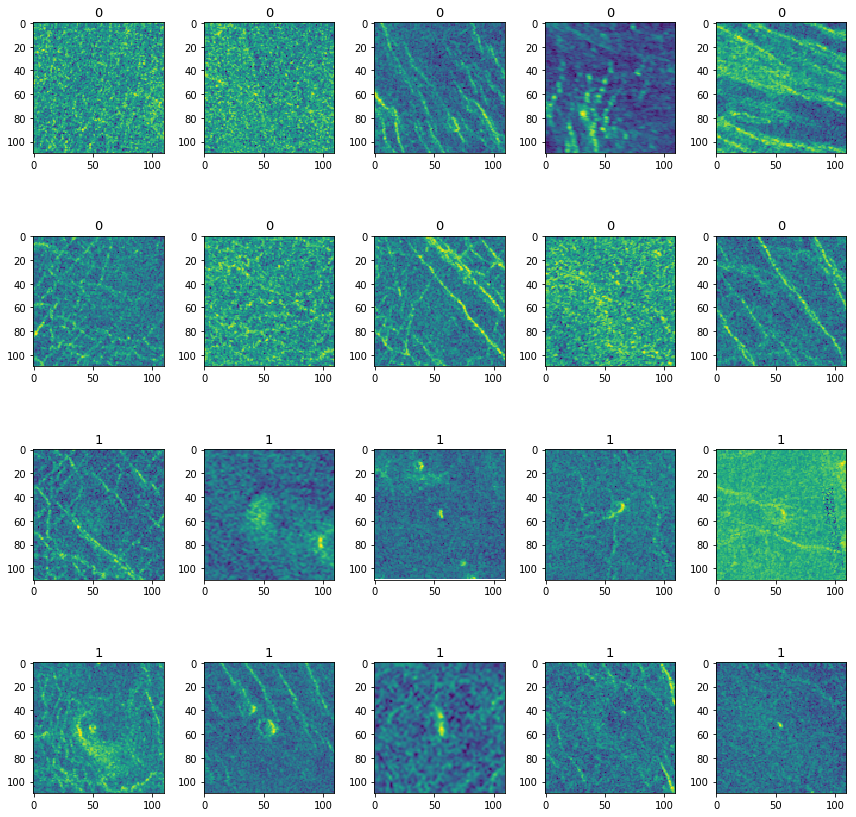

In [19]:
draw_images("Volcano?")

In [20]:
y_train.head()

Volcano?  Type  Radius  Number Volcanoes       label
0         1   3.0   17.46               1.0     Volcano
1         0   NaN     NaN               NaN  No Volcano
2         0   NaN     NaN               NaN  No Volcano
3         0   NaN     NaN               NaN  No Volcano
4         0   NaN     NaN               NaN  No Volcano

In [21]:
x_train_shaped[0]

array([[ 95, 101,  99, ...,  87,  90,  93],
       [ 77,  75,  84, ...,  91,  79,  84],
       [ 95,  94,  89, ..., 105,  86,  88],
       ...,
       [ 87,  94,  97, ...,  94,  92,  90],
       [ 81,  94,  91, ..., 102,  82,  91],
       [ 98, 106, 110, ..., 116, 118,  96]], dtype=int64)

In [22]:
x_train.head()

0      1      2      3      4      5      6      7      8      9      ...  \
0     95    101     99    103     95     86     96     89     70    104  ...   
1     91     92     91     89     92     93     96    101    107    104  ...   
2     87     70     72     74     84     78     93    104    106    106  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4    114    118    124    119     95    118    105    116    123    112  ...   

   12090  12091  12092  12093  12094  12095  12096  12097  12098  12099  
0    111    107     92     89    103     99    117    116    118     96  
1    103     92     93     95     98    105    104    100     90     81  
2     84     71     95    102     94     80     91     80     84     90  
3     94     81     89     84     80     90     92     80     88     96  
4    116    113    102     93    109    104    106    117    111    115  

[5 rows x 12100 columns]

## Alternative Approach to Solving Corrupted Images

Differing approach from what I've seen, where others implemented a solution that involves iterating over 10 pixels at a time over an image, and if their sum is zero (all values are of 0 on the rgb scale) then the image is considered partially corrupted. The corrupted images are then removed entirely from the training set. However, this would still remove images that are even only slightly corrupted in upper corners or in significantly smaller patches. I believe that an alternative method where we consider the overall proportion of the image that is corrupted is better suited for this scenario, so that this can ultimately preserve additional images for the training set of data.

In [23]:
def detect_corrupted_image(image_, percentage_corrupted=0.15):
    '''
    input: 
        image_: flattened 110x110 image input 
        percentage_corrupted: percentage threshold for an image to be considered corrupted
    returns: 
        result: 0 if not corrupted; 1 if corrupted
    '''
    
    pixel_count = [True if i == 0 else False for i in image_]
    total_corrupted = sum(pixel_count)/12100
    if total_corrupted > percentage_corrupted:
        result = 1
    else:
        result = 0
    return result

In [24]:
x_train.shape[0]

7000

In [25]:
x_train.iloc[0].values

array([ 95, 101,  99, ..., 116, 118,  96], dtype=int64)

In [26]:
corrupted_detected = np.array([detect_corrupted_image(x_train.iloc[i].values, .1) for i in tqdm(range(x_train.shape[0]))])

100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [02:24<00:00, 86.43it/s]


In [27]:
corrupted_indexes = np.where(corrupted_detected == 1)[0]
print("Total Corrupted Images: ", len(corrupted_indexes))

Total Corrupted Images:  240


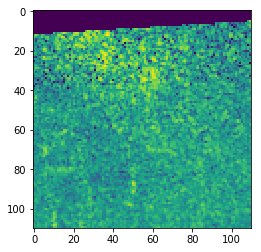

In [28]:
plt.imshow(x_train_shaped[3])
plt.show()

In [29]:
corrupted_images = x_train_shaped[corrupted_indexes]

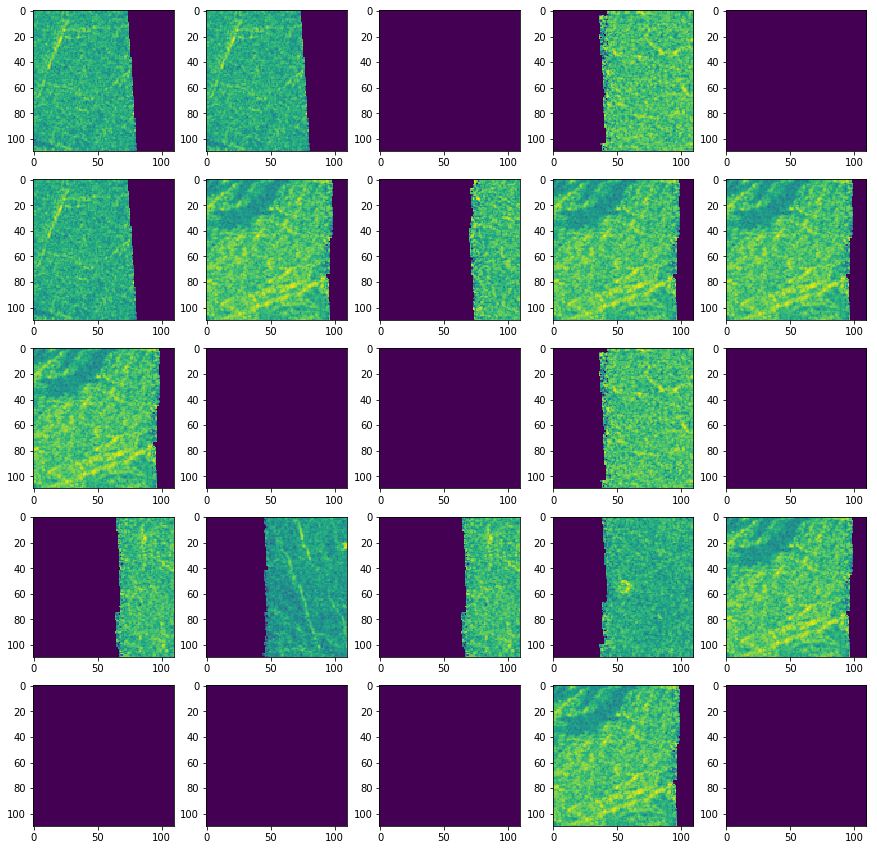

In [30]:
import random
random.shuffle(corrupted_images)

f, axarr = plt.subplots(5,5,figsize=(15,15))
for i in range(5):
    for j in range(5):
        axarr[i,j].imshow(corrupted_images[i*5+j])

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
#x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=22)